<a href="https://colab.research.google.com/github/jeonghojo00/SpeechRecognition/blob/main/SpeechRecognition_MedicalSpeech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Target 1: Convert Wav file into Text
 Target 2: Analyze symptoms with text

## Step 0. Connect to Google Drive

In [1]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Change current directory
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/SpeechRecognition/MedicalSpeech')


In [3]:
# Import Overview csv file
import pandas as pd

#Analyze Data
def explore_data(df):
    print(f"The data contains {df.shape[0]} rows and {df.shape[1]} columns.")
    print('\n')
    print('Dataset columns:',df.columns)
    print('\n')
    print(df.info())

filename = "overview-of-recordings.csv"
overview = pd.read_csv(filename)
explore_data(overview)

The data contains 6661 rows and 13 columns.


Dataset columns: Index(['audio_clipping', 'audio_clipping:confidence',
       'background_noise_audible', 'background_noise_audible:confidence',
       'overall_quality_of_the_audio', 'quiet_speaker',
       'quiet_speaker:confidence', 'speaker_id', 'file_download', 'file_name',
       'phrase', 'prompt', 'writer_id'],
      dtype='object')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6661 entries, 0 to 6660
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   audio_clipping                       6661 non-null   object 
 1   audio_clipping:confidence            6661 non-null   float64
 2   background_noise_audible             6661 non-null   object 
 3   background_noise_audible:confidence  6661 non-null   float64
 4   overall_quality_of_the_audio         6661 non-null   float64
 5   quiet_speaker                      

## Step 1. Preprocessing

##### Preprocessing includes following actions:
1. Load audio file
2. Load csv file
3. Convert audio file into spectrogram feature, mfcc feature
4/ 

### Step 1-1. Import train, validate, and test corpus json files

In [4]:
import json

f = open('train_corpus.json',)
train_corpus = json.load(f)

f = open('validate_corpus.json',)
validate_corpus = json.load(f)

f = open('test_corpus.json',)
test_corpus = json.load(f)
  

### Step 1-2. Define functions for various wavelengths

In [5]:
# Transform wav into signal and rate
import librosa, librosa.display

signal, sr = librosa.load(train_corpus[0]["key"], sr=22050)

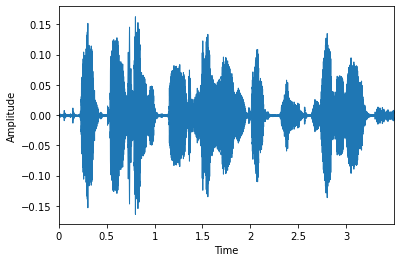

In [6]:
# WaveForm

import matplotlib.pyplot as plt

librosa.display.waveplot(signal, sr=sr)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

In [54]:
import librosa, librosa.display

def to_spectrogram(file_path, sr=22050, plot=False):
    # Transform wav into signal and rate
    signal, sr = librosa.load(file_path, sr=sr)

    # Spectrogram
    n_fft = 2048 # Number of samples per fft
    hop_length = 512 # Amount we shift to the right

    stft = librosa.core.stft(signal, hop_length=hop_length, n_fft = n_fft)
    spectrogram = np.abs(stft)

    log_spectrogram = librosa.amplitude_to_db(spectrogram)
    
    if plot:
        # Plot the result
        librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop_length)
        plt.xlabel("Time")
        plt.ylabel("Frequency")
        plt.colorbar()
        plt.show()
        
    return log_spectrogram

In [55]:
import numpy as np
def normalize(feature, eps=1e-14):
        """ Center a feature using the mean and std
        Params:
            feature (numpy.ndarray): Feature to normalize
        """
        feats_mean = np.mean(log_spectrogram, axis=0)
        feats_std = np.std(log_spectrogram, axis=0)
        return (feature - feats_mean) / (feats_std + eps)

In [56]:
def to_mfcc(file_path, sr=22050, plot=False):
    # MFCCs
    signal, sr = librosa.load(train_corpus[0]["key"], sr=sr)
    MFCCs = librosa.feature.mfcc(signal, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)

    if plot:
        librosa.display.specshow(MFCCs, sr=sr, hop_length=hop_length)
        plt.xlabel("Time")
        plt.ylabel("Frequency")
        plt.colorbar()
        plt.show()


In [57]:
def to_spectrum(file_path, sr=22050, plot=False):
    # Spectrum
    # Transform wav into signal and rate
    signal, sr = librosa.load(train_corpus[0]["key"], sr=sr)

    fft = np.fft.fft(signal)
    magnitude = np.abs(fft)
    frequency = np.linspace(0, sr, len(magnitude))

    # Because once we pass over the half, we repeat the same information. we use only the first half
    left_frequency = frequency[:int(len(frequency)/2)]
    left_magnitude = magnitude[:int(len(magnitude)/2)]

    if plot:

        plt.plot(left_frequency, left_magnitude)
        plt.xlabel("Frequency")
        plt.ylabel("Magnitude")
        plt.show()
    

### Step 1.3. Prepare Datasets

In [84]:
SPACE_TOKEN = '<space>'
SPACE_INDEX = 0
FIRST_INDEX = ord('a') - 1  # 0 is reserved to space

def convert_inputs_to_ctc_format(audio_path, feature, text, samplerate=22050):
    # Convert auido file into audio feature in 3D
    ## Load audio file into selected feature
    if feature == "spectrogram":
        inputs = to_spectrogram(audio_path, sr=samplerate)
    elif feature == "mfcc":
        inputs = to_mfcc(audio_path, sr=samplerate)
    elif feature == "spectrum":
        inputs = to_spectrum(audio_path, sr=samplerate)
    
    ## Change inputs into 3D
    train_inputs = np.asarray(inputs[np.newaxis, :])
    train_inputs = (train_inputs - np.mean(train_inputs)) / np.std(train_inputs)
    train_seq_len = [train_inputs.shape[1]]

    # Get only the words between [a-z] and replace period for none
    original = ' '.join(text.strip().lower().split(' '))\
                  .replace('.', '').replace('?', '').replace(',','').replace("'", '').replace('!', '').replace('-', '')

    targets = original.replace(' ', '  ')
    targets = targets.split(' ')

    # Adding blank label
    targets = np.hstack([SPACE_TOKEN if x == '' else list(x) for x in targets])

    # Transform char into index
    targets = np.asarray([SPACE_INDEX if x == SPACE_TOKEN else ord(x) - FIRST_INDEX
                          for x in targets])

    return train_inputs, targets, train_seq_len, original




In [85]:
sample_rate = 8000
# Some configs
num_features = 13  # log filter bank or MFCC features
# Accounting the 0th index +  space + blank label = 28 characters
num_classes = ord('z') - ord('a') + 1 + 1 + 1

# Hyper-parameters
num_epochs = 100000
num_hidden = 256
batch_size = 16

num_examples = 1
num_batches_per_epoch = 10


def decode_batch(d, original, phase='training'):
    aligned_original_string = ''
    aligned_decoded_string = ''
    for jj in range(batch_size)[0:2]:  # just for visualisation purposes. we display only 2.
        values = d.values[np.where(d.indices[:, 0] == jj)[0]]
        str_decoded = ''.join([chr(x) for x in np.asarray(values) + FIRST_INDEX])
        # Replacing blank label to none
        str_decoded = str_decoded.replace(chr(ord('z') + 1), '')
        # Replacing space label to space
        str_decoded = str_decoded.replace(chr(ord('a') - 1), ' ')
        maxlen = max(len(original[jj]), len(str_decoded))
        aligned_original_string += str(original[jj]).ljust(maxlen) + ' | '
        aligned_decoded_string += str(str_decoded).ljust(maxlen) + ' | '
    print('- Original (%s) : %s ...' % (phase, aligned_original_string))
    print('- Decoded  (%s) : %s ...' % (phase, aligned_decoded_string))

In [83]:
target_text = train_corpus[0]['text']
train_X, train_y, train_seq_len, original = convert_inputs_to_ctc_format(audio_path = train_corpus[0]['key'], feature="spectrogram", text = train_corpus[0]['text'])

In [97]:
train_y

array([ 9,  0, 20,  8,  9, 14, 11,  0,  9,  0, 19, 16, 18,  1,  9, 14,  5,
        4,  0, 13, 25,  0,  1, 14, 11, 12,  5,  0,  9, 20,  0, 18,  5,  1,
       12, 12, 25,  0,  8, 21, 18, 20, 19])

In [98]:
SPACE_TOKEN = '<space>'
SPACE_INDEX = 0
FIRST_INDEX = ord('a') - 1  # 0 is reserved to space

def decode_text(y_predict, original):
    aligned_original_string = ''
    aligned_decoded_string = ''

    str_decoded = ''.join([chr(x) for x in np.asarray(y_predict) + FIRST_INDEX])

    str_decoded = str_decoded.replace(chr(ord('z') + 1), '')
    # Replacing space label to space
    str_decoded = str_decoded.replace(chr(ord('a') - 1), ' ')
    maxlen = max(len(original), len(str_decoded))
    aligned_original_string += str(original).ljust(maxlen)
    aligned_decoded_string += str(str_decoded).ljust(maxlen)

    print('- Original: %s' % (aligned_original_string))
    print('- Decoded : %s' % (aligned_decoded_string))



i`think`i`sprained`my`ankle`it`really`hurts
i think i sprained my ankle it really hurts
- Original: i think i sprained my ankle it really hurts
- Decoded : i think i sprained my ankle it really hurts


In [70]:
def sparse_tuple_from(sequences, dtype=np.int32):
    """Create a sparse representention of x.
    Args:
        sequences: a list of lists of type dtype where each element is a sequence
    Returns:
        A tuple with (indices, values, shape)
    """
    indices = []
    values = []

    for n, seq in enumerate(sequences):
        indices.extend(zip([n] * len(seq), range(len(seq))))
        values.extend(seq)

    indices = np.asarray(indices, dtype=np.int64)
    values = np.asarray(values, dtype=dtype)
    shape = np.asarray([len(sequences), np.asarray(indices).max(0)[1] + 1], dtype=np.int64)

    return indices, values, shape

In [71]:
y_list = []
y_list.append(train_y)

In [72]:
def decode_batch(d, original, phase='training'):
    aligned_original_string = ''
    aligned_decoded_string = ''
    for jj in range(batch_size)[0:2]:  # just for visualisation purposes. we display only 2.
        values = d.values[np.where(d.indices[:, 0] == jj)[0]]
        str_decoded = ''.join([chr(x) for x in np.asarray(values) + FIRST_INDEX])
        # Replacing blank label to none
        str_decoded = str_decoded.replace(chr(ord('z') + 1), '')
        # Replacing space label to space
        str_decoded = str_decoded.replace(chr(ord('a') - 1), ' ')
        maxlen = max(len(original[jj]), len(str_decoded))
        aligned_original_string += str(original[jj]).ljust(maxlen) + ' | '
        aligned_decoded_string += str(str_decoded).ljust(maxlen) + ' | '
    print('- Original (%s) : %s ...' % (phase, aligned_original_string))
    print('- Decoded  (%s) : %s ...' % (phase, aligned_decoded_string))

In [73]:
sparsed

(array([[ 0,  0],
        [ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0,  9],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 14],
        [ 0, 15],
        [ 0, 16],
        [ 0, 17],
        [ 0, 18],
        [ 0, 19],
        [ 0, 20],
        [ 0, 21],
        [ 0, 22],
        [ 0, 23],
        [ 0, 24],
        [ 0, 25],
        [ 0, 26],
        [ 0, 27],
        [ 0, 28],
        [ 0, 29],
        [ 0, 30],
        [ 0, 31],
        [ 0, 32],
        [ 0, 33],
        [ 0, 34],
        [ 0, 35],
        [ 0, 36],
        [ 0, 37],
        [ 0, 38],
        [ 0, 39],
        [ 0, 40],
        [ 0, 41],
        [ 0, 42]]),
 array([ 9,  0, 20,  8,  9, 14, 11,  0,  9,  0, 19, 16, 18,  1,  9, 14,  5,
         4,  0, 13, 25,  0,  1, 14, 11, 12,  5,  0,  9, 20,  0, 18,  5,  1,
        12, 12, 25,  0,  8, 21, 18, 20, 19], dtype=int32),
 array([ 1, 4

In [68]:
batch_size = 16

def decode_batch(d, original, phase='training'):
    aligned_original_string = ''
    aligned_decoded_string = ''
    for jj in range(batch_size)[0:2]:  # just for visualisation purposes. we display only 2.
        values = d.values[np.where(d.indices[:, 0] == jj)[0]]
        str_decoded = ''.join([chr(x) for x in np.asarray(values) + FIRST_INDEX])
        # Replacing blank label to none
        str_decoded = str_decoded.replace(chr(ord('z') + 1), '')
        # Replacing space label to space
        str_decoded = str_decoded.replace(chr(ord('a') - 1), ' ')
        maxlen = max(len(original[jj]), len(str_decoded))
        aligned_original_string += str(original[jj]).ljust(maxlen) + ' | '
        aligned_decoded_string += str(str_decoded).ljust(maxlen) + ' | '
    print('- Original (%s) : %s ...' % (phase, aligned_original_string))
    print('- Decoded  (%s) : %s ...' % (phase, aligned_decoded_string))

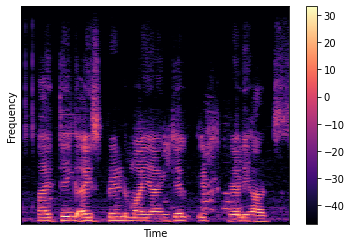

In [43]:
inputs = to_spectrogram(train_corpus[0]['key'], plot=True)

In [44]:
train_inputs = np.asarray(inputs[np.newaxis, :])
train_inputs = (train_inputs - np.mean(train_inputs)) / np.std(train_inputs)
train_seq_len = [train_inputs.shape[1]]

In [45]:
train_seq_len

[1025]

## Step 2. Build Model

In [16]:
'''
Recurrent Neural Network works weell in sequential data better than Feed Forward Neural Network
Because speech is sequential data, we use Recurrent Neural Network
'''


'\nRecurrent Neural Network works weell in sequential data better than Feed Forward Neural Network\n'